# Assignment 1:  Superpixels and Image Segmentation.

Name: **Mayank Sharma**

UID:  **119203859**

Link to Google Drive : **https://colab.research.google.com/drive/1zTEH4JB50L0LNoMFQXPew-BL1RH7oHGL**

Please submit a PDF containing all outputs to gradescope by **October 5, 11:59pm**

----------------------------

In this assignment, you will learn about superpixels. You will first generate superpixels by clustering pixels via k-means. This will generate a superpixel map such as the following:

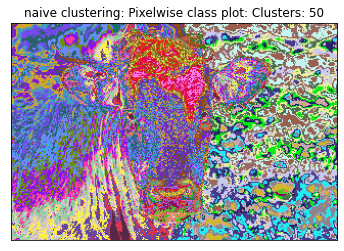

You will then implement a better superpixel algorithm: SLIC, which lets you generate superpixel maps like the following:

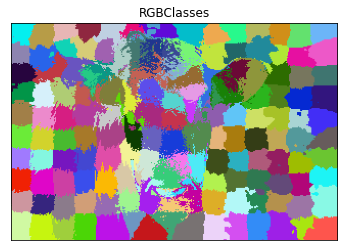

You will then build a segmentation network by training a deep neural network on your superpixels. This part is fairly open-ended, feel free to try any model you can think of (GNN, CNN, Transformer, etc.).

To give an example, for a CNN-based system that reformulates segmentation as superpixel image classification, there are basically three steps in the training stage:

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label.
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.

Then, during inference, you would combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Part 1: Superpixels

For this first part of the assignment, you will implement 2 superpixels methods: k-means pixel clustering, and SLIC.

### Data

First, we download the MSRC labeled imaged database.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2023-10-05 20:14:56--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.46.189.29, 2600:1401:4000:481::317f, 2600:1401:4000:49d::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.46.189.29|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2023-10-05 20:14:56--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.46.189.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  24

For the first part of this assignment, we will only use the following images. We define the list below as `im_list`.

In [ ]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.





In [ ]:
#All important functions to plot
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im, title, xticks = [], yticks = [], isCv2 = True):
    """
    im :Image to plot
    title : Title of image
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm),
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value

    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot

    Output: None
    Creates a plot
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]

    plot_image(seg_img,title)

    return None

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    #This clust gives unique labels
    clust = np.unique(seg)

    if n is None:
        n = len(clust)

    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust}
    # elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict
    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
          seg_img[seg == i] = mapper_dict[i][:3]
    # mapper_dict = {i: seg_img[seg == i].mean/255. for i in clust}
      #     cluster_color = np.mean(seg_img[seg], axis=(0, 1))
      #     mean_color_cluster.append(cluster_color)
    if plot:
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

For example, the following code uses `plot_image` to plot the 6 images we are using for this assignment.

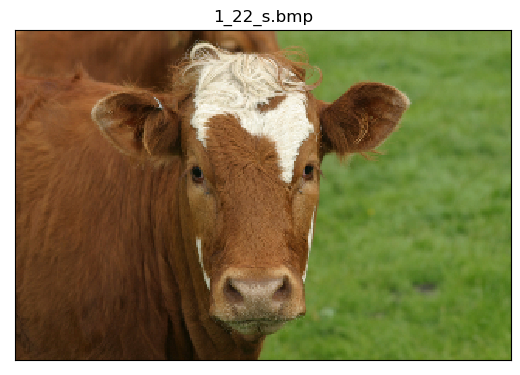

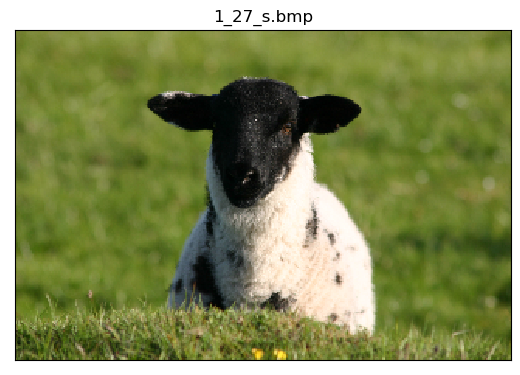

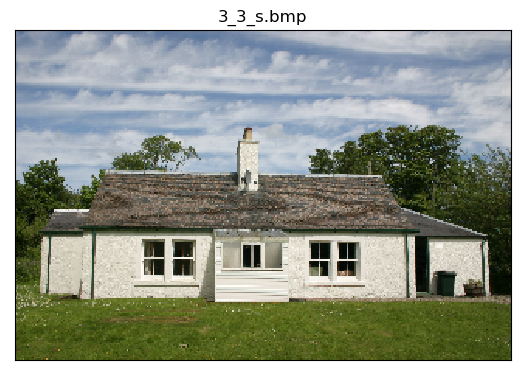

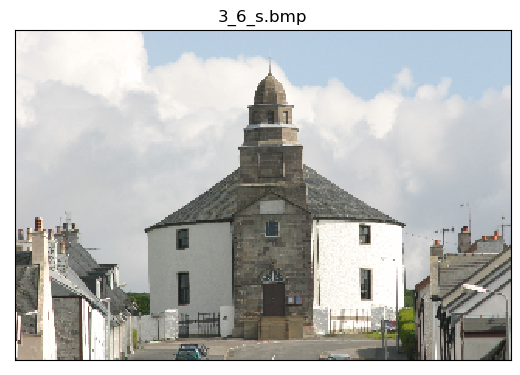

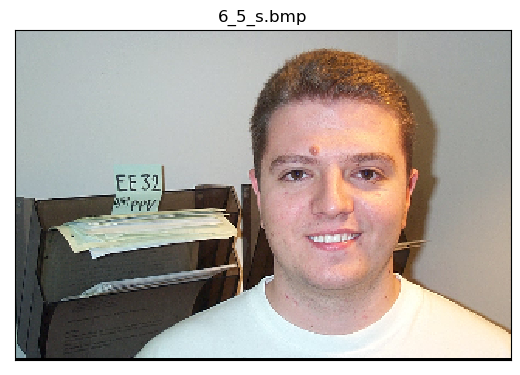

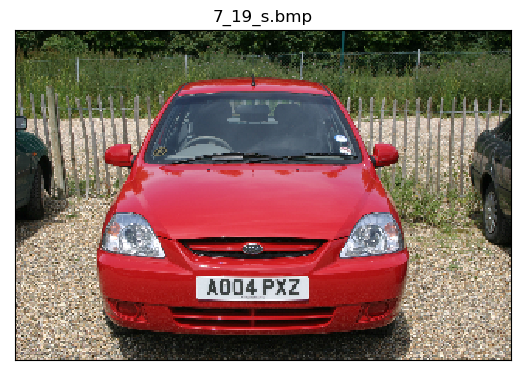

In [ ]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

### Question 1: Perform k-means on image pixels `(r, g, b, x, y)`. (40 points)

The k-means clustering algorithm is an unsupervised algorithm which, for some items and for some specified number of clusters represented by cluster centers, minimizes the distance between items and their associated cluster centers. It does so by iteratively assigning items to a cluster and recomputing the cluster center based on the assigned items.

Complete the pixel clustering function. It should take input an image (shape = `(n, m, 3)`) and number of clusters. Each pixel should be represented by a vector with 3 values: `(r, g, b, x, y)`.

Then, let our provided code plot the pixelwise and superpixel plots for the cow image (`1_22_s.bmp`), using your `cluster_pixels` implementation with the provided values for the number of clusters: `5, 10, 25, 50, 150`.




/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

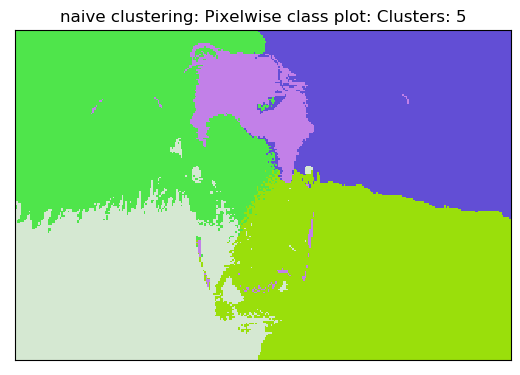

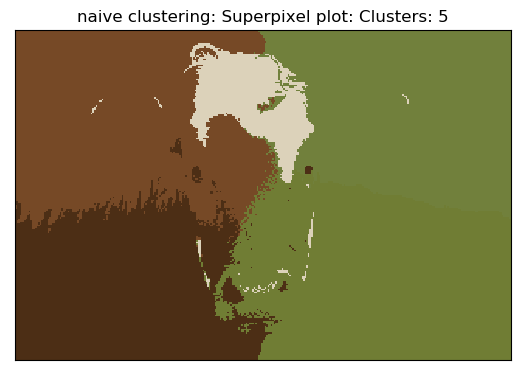

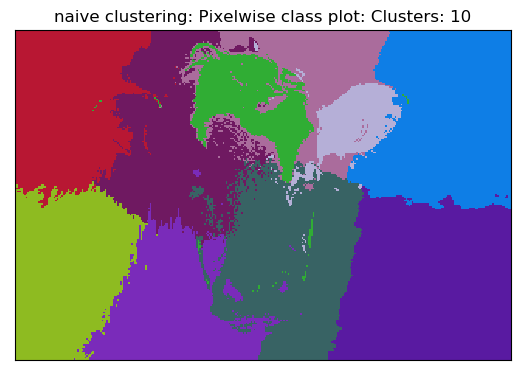

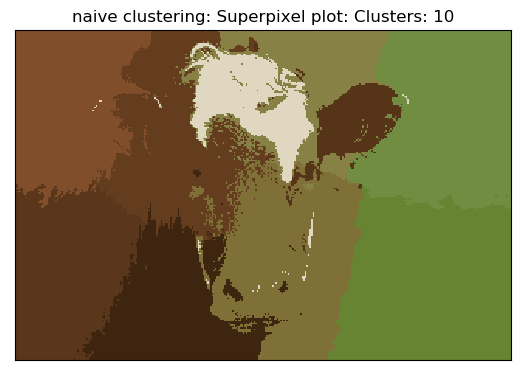

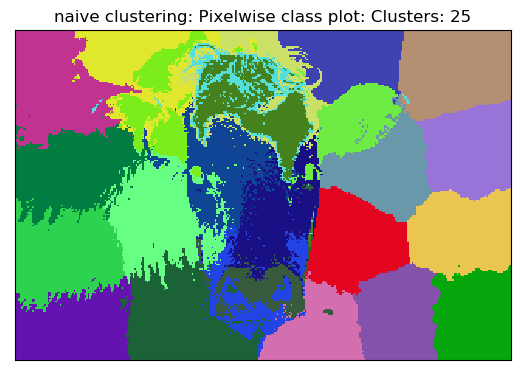

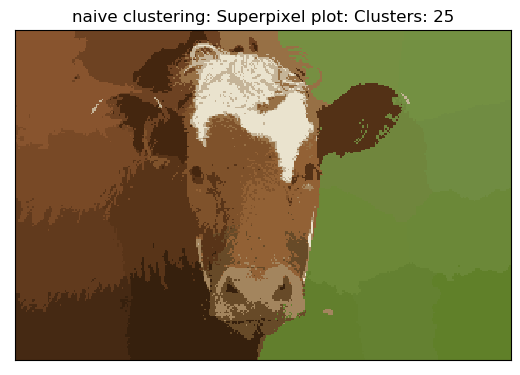

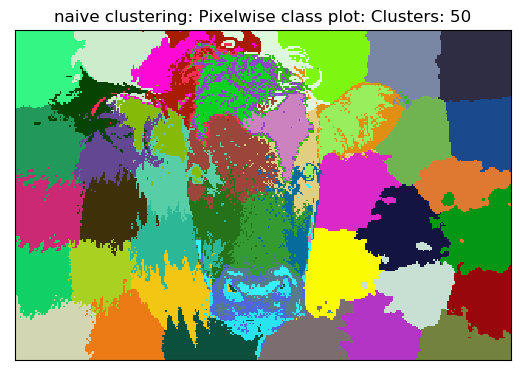

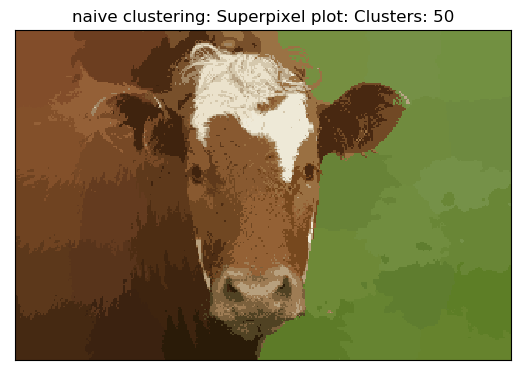

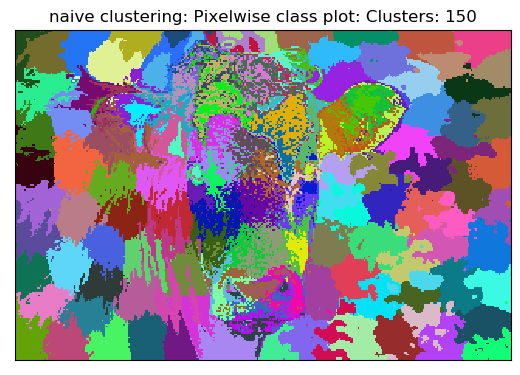

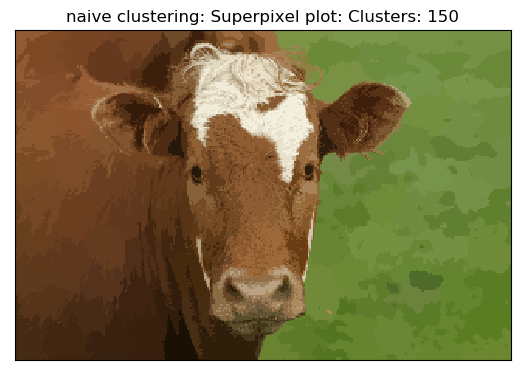

In [ ]:
from sklearn.cluster import KMeans
import numpy as  np

def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    # assert 1==2," NOT IMPLEMENTED"
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel

    Image_rgb = im.reshape((-1, 3))
    height, width, _ = im.shape

    x, y = np.meshgrid(np.arange(width), np.arange(height))
    xy = np.column_stack((x.reshape(-1), y.reshape(-1)))

    # After we get r,g,b,x,y we stack them in a feature matrix
    features = np.column_stack((Image_rgb, xy))
    # Performing k-means clustering algorithm on r,g,b,x,y
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    # give labels to each pixel
    labels = kmeans.labels_
    #Reshape the labels back to the original image shape
    segmap = labels.reshape(im.shape[:2])


    return segmap

im = cv2.imread(im_list[0])
for k in [5, 10, 25, 50, 150]:
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

Pick your favorite superpixel **k** value and plot results for all 6 images in `im_list`.

/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mayank/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

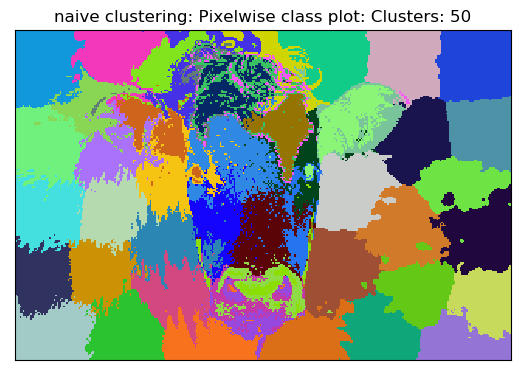

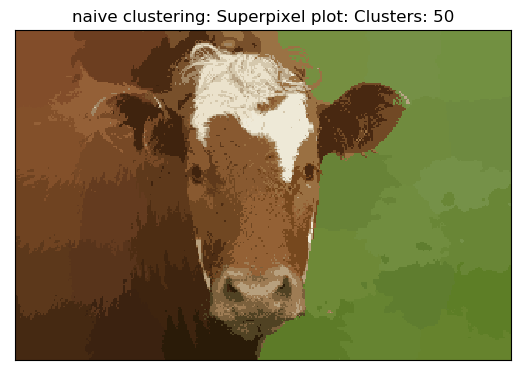

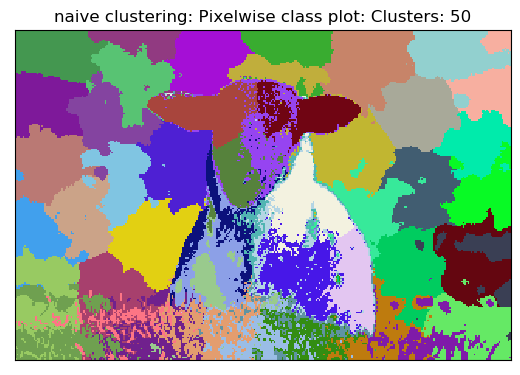

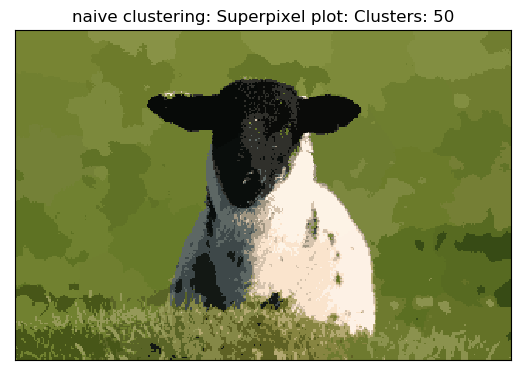

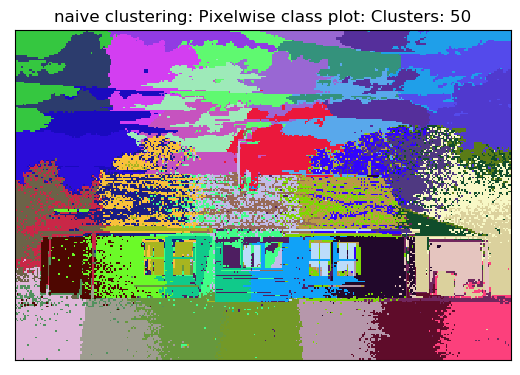

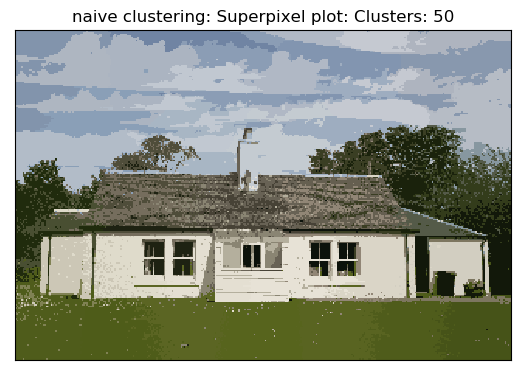

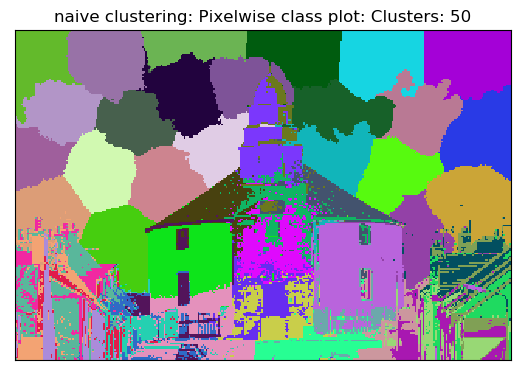

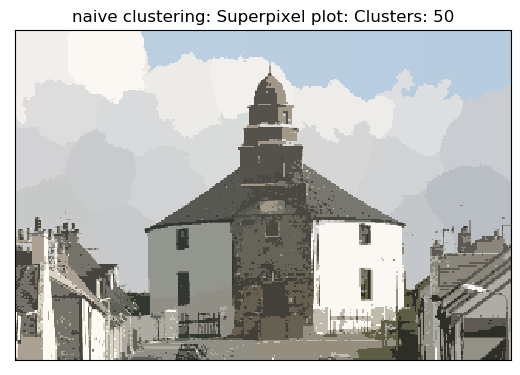

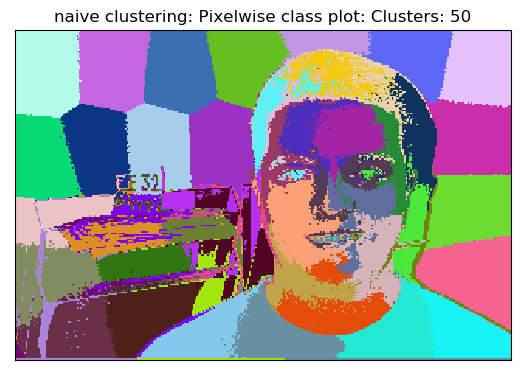

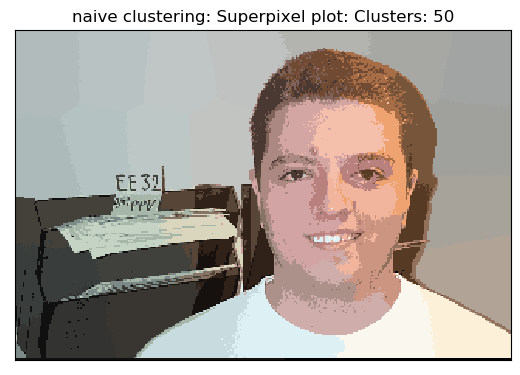

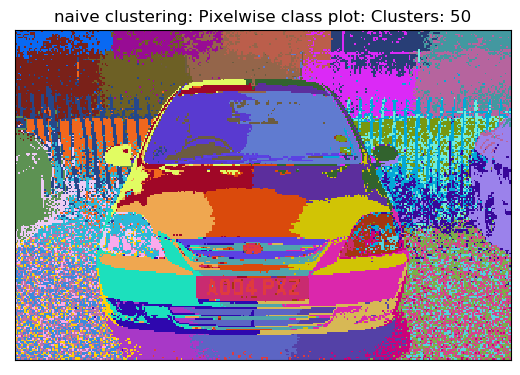

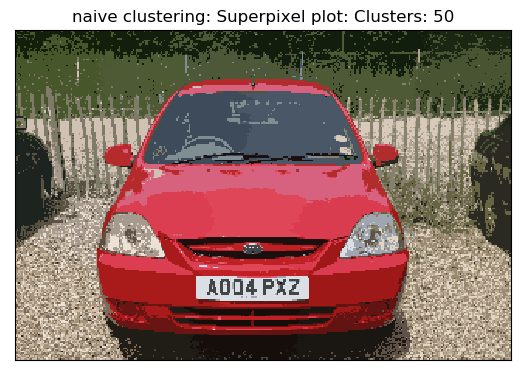

In [ ]:
# TODO: plot for 6 images with chosen k value

# My pick is K=50
k=50
for i in im_list:
    im=cv2.imread(i)
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))



### Question 2: Replicate SLIC and Show Results for 6 Images (50 points)

It doesn't look like we have a very favourable outcome with superpixels being implemented with simple clustering. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.

**Finding an existing implementation of SLIC and using it for your assigment would be considered cheating.**

In [ ]:
from skimage.util import img_as_float
from skimage import io, color
import math
import time
import copy
import cv2

In [ ]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):
    def __init__(self, h, w, l=0, a=0, b=0):
        self.update( h, w,l, a, b)
        self.pixels = []
    def update(self, h, w ,l, a, b):

        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,image):
    return SuperPixel( h, w,image[h,w][0],image[h,w][1],image[h,w][2])

In [ ]:
# Functions for Simple Linear Iterative Clustering (SLIC)
def get_lab(image):
  image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB).astype(np.float64)
  return image_lab

def initializing_cluster_centers(S, image, image_height, image_width, clusters):
    # Initializing clusters by sampling pixels at an equally sampled regular grid (distanced by S)
    h = S // 2
    w = S // 2
    while h < image_height:
        while w < image_width:
          clusters.append(make_SuperPixel(h, w,image))
          w= w+S
        w = S // 2
        h =  S + h
    return clusters


def get_cluster_gradient(h,w,image,image_width,image_height):
    #Calculating gradient of the cluster
    gradient=np.linalg.norm(image[h+1, w] - image[h-1,w])**2 + np.linalg.norm(image[h, w+1] - image[h, w-1])**2
    return gradient

def relocating_cluster_center_to_lowgradients(clusters, image,image_width,image_height):
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient.
    for i in clusters:
      minimum_gradient = get_cluster_gradient(i.h,i.w,image,image_width,image_height)
      for j in range(-1,2):
          for k in range(-1,2):
            Height_new = i.h + j
            Width_new = i.w + k
            new_cluster_grad = get_cluster_gradient(Height_new,Width_new,image,image_width,image_height)
            if new_cluster_grad<minimum_gradient:
              i.update(Height_new,Width_new,image[Height_new,Width_new][0],image[Height_new,Width_new][1],image[Height_new,Width_new][2])
              minimum_gradient = new_cluster_grad
    return None

def assign_pixels_2_cluster(clusters, S, image, image_height, image_width, cluster_dict, dis,segmap,m):

    # Comparing each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster

  for idx, i in enumerate(clusters):
    for h in range(i.h-2*S,i.h+2*S):
      if h<0 or h>=image_height: continue
      for w in range(i.w-2*S,i.w+2*S):
          if w<0 or w>=image_width: continue
          l,a,b = image[h,w]
          distance_color = math.sqrt(math.pow(l-i.l,2)+math.pow(a-i.a,2)+math.pow(b-i.b,2))
          distance_spatial = math.sqrt(math.pow(h-i.h,2)+math.pow(w-i.w,2))
          D = distance_color + (distance_spatial*m/S)
          if D < dis[h,w]:
            if (h,w) not in cluster_dict:
              cluster_dict[(h,w)] = i
              i.pixels.append((h,w))
            else:
              cluster_dict[(h,w)].pixels.remove((h,w))
              cluster_dict[(h,w)] = i
              i.pixels.append((h,w))
            dis[h,w] = D
            segmap[h,w]=idx
  return segmap

def update_clusters(clusters):
  # For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
  for i in clusters:
    H = W = count = 0
    for pix in i.pixels:
      H = H + pix[0]
      W = W + pix[1]
      count = count + 1
      H_mean = H//count
      W_mean = W//count
      i.update(H_mean,W_mean,image[H_mean,W_mean][0],image[H_mean,W_mean][1],image[H_mean,W_mean][2])
  return None

In [ ]:

def SLIC(im,k):
    """
    Input arguments:
    im: image input
    k: number of cluster segments
    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..

    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number

    """
    #I have set m=10 according to the paper
    m=10# compactness factor, more the m, more spatial proximity so more compact[1,20]
    N = image_height * image_width  # number of pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    clusters = []
    # cluster_dict contain cluster-assignment for each pixel.
    cluster_dict = {}
    #Initializing cluster centers
    clusters = initializing_cluster_centers(S, image, image_height, image_width, clusters)
    # Move centers to position in 3x3 window with smallest gradient.
    relocating_cluster_center_to_lowgradients(clusters, image,image_width,image_height)
    #initialiatize segmentation map
    segmap=np.zeros(image.shape[:2])
    # Distance between pixels and cluster is initialized as infinity at the beginning.
    distance = np.full((image_height, image_width), np.inf)
    segmap=assign_pixels_2_cluster(clusters, S, image, image_height, image_width, cluster_dict, distance,segmap,m)
    # old_clusters = copy.deepcopy(clusters)
    update_clusters(clusters)
    # return segmap
    return segmap







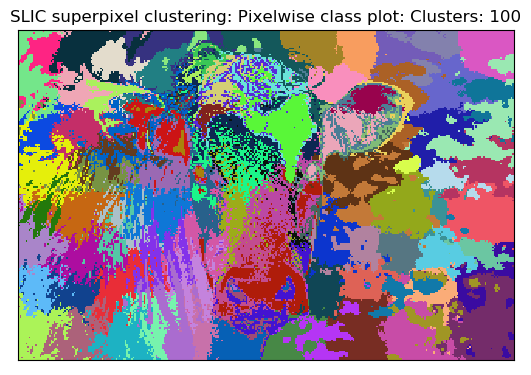

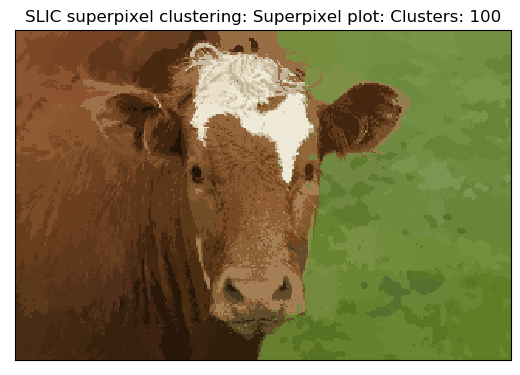

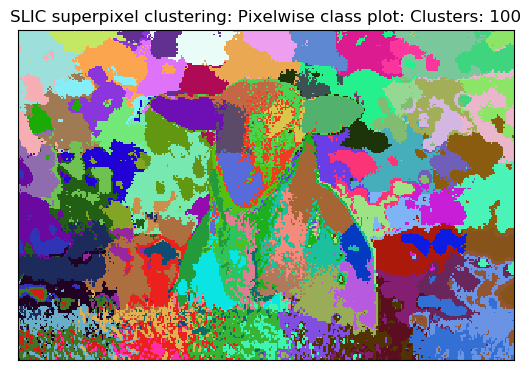

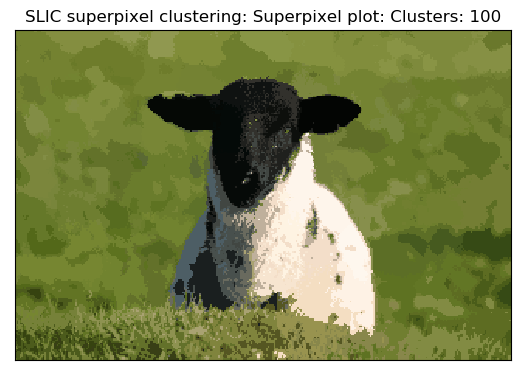

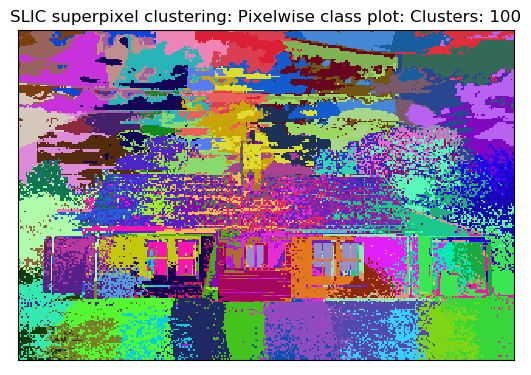

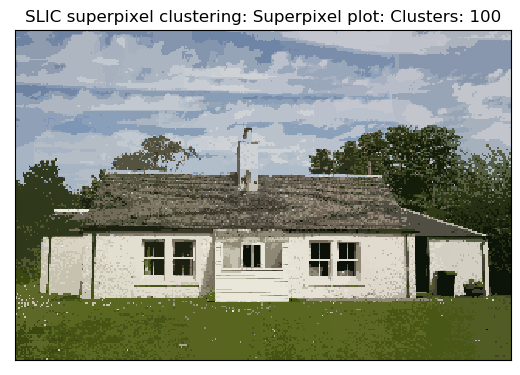

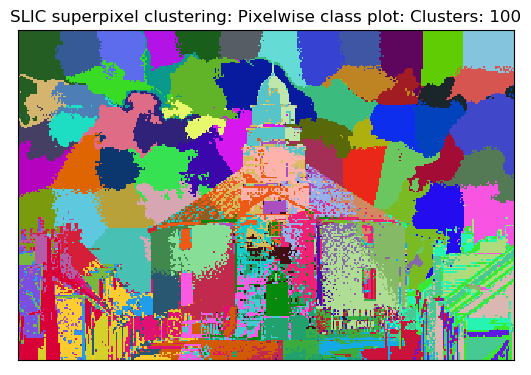

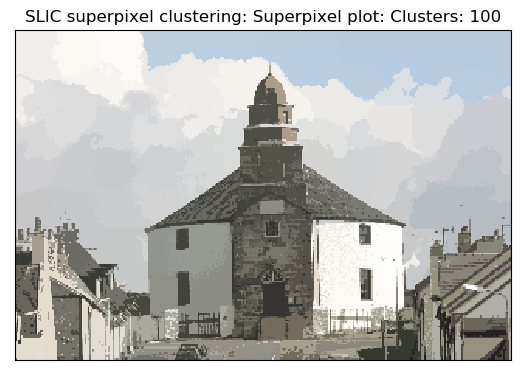

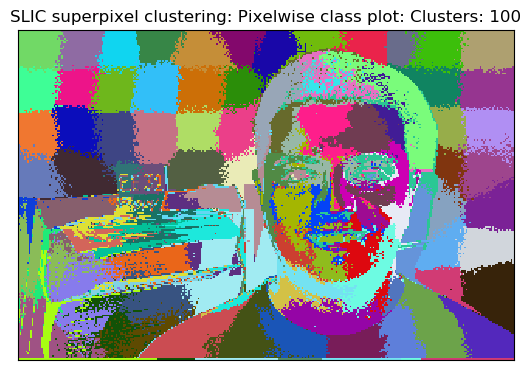

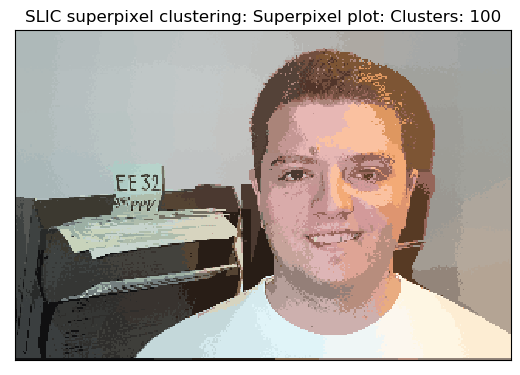

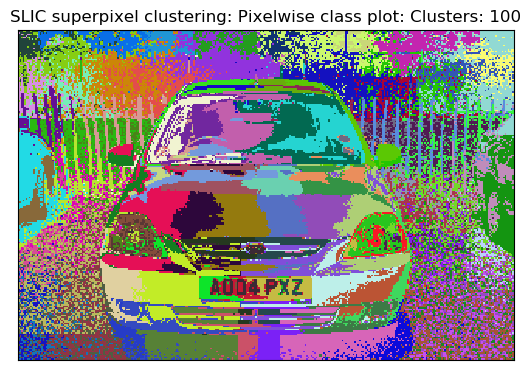

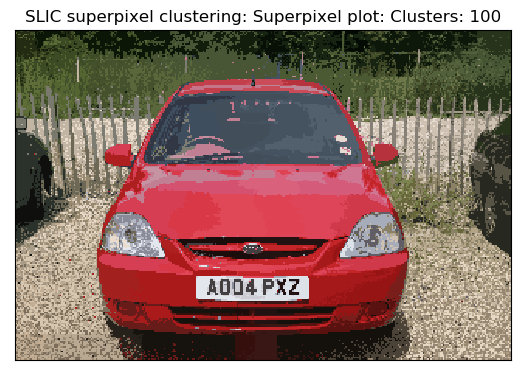

In [ ]:
## TODO: Call our plot functions with your SLIC results for all 6 images

k=100
for i in im_list:
  image_RGB=cv2.imread(i)
  image_height=image_RGB.shape[0]
  image_width=image_RGB.shape[1]
  image= get_lab(image_RGB)
  clusters = SLIC(image, k)
  _ = rgb_segment(clusters,n = k, title =  "SLIC superpixel clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(image_RGB,clusters,title =  "SLIC superpixel clustering: Superpixel plot: Clusters: "+ str(k))



With SLIC implemented, plot results for all 6 images.

### Question 3: What advantage did the SLIC give compared to `(r, g, b, x, y)`? Please answer in 3 sentences or fewer. (10 points)

Your Answer:

CIELAB color space used in SLIC is widely considered as perceptually uniform for small color distances compared to (r,g,b,x,y). In addition we get compact superpixels, improved efficiency and better segmentation.



### Bonus Question 4: Enforce connectivity (20 points, OPTIONAL)
There are many superpixels which are very small and disconnected from each other. Merge them with larger superpixels

O(N) algorithm:
1. Set minimum size of superpixel
2. If region smaller than threshold, assign to nearest cluster

Plot results for the 6 images.


## Part 2: Segmentation

For this part, you will use your best superpixels to build an image segmentation system. Alternatively, you can use SLIC from some library, as we demonstrate in the Data section that follows.

### Data

This is mostly the same as the last part, except now we also need to consider the annotated ground truth segmentation maps.

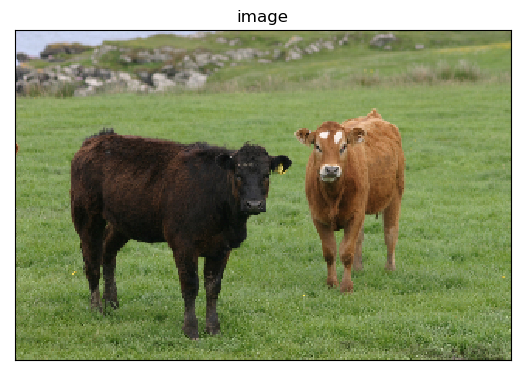

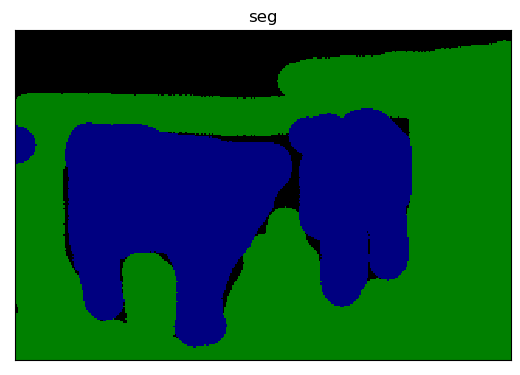

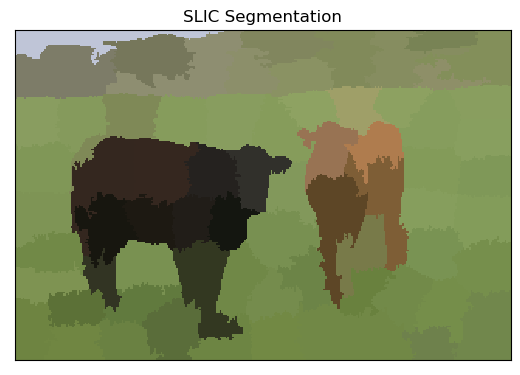

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [ ]:
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": -1, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": -1, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": -1, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": -1, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
labels_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    labels_2_rgb[i['id']] = i['rgb_values']




### Question 5: Superpixel Dataset (30 points)

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label.

For the purpose of consistency, we adopt the existing SLIC implementation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>italicized text

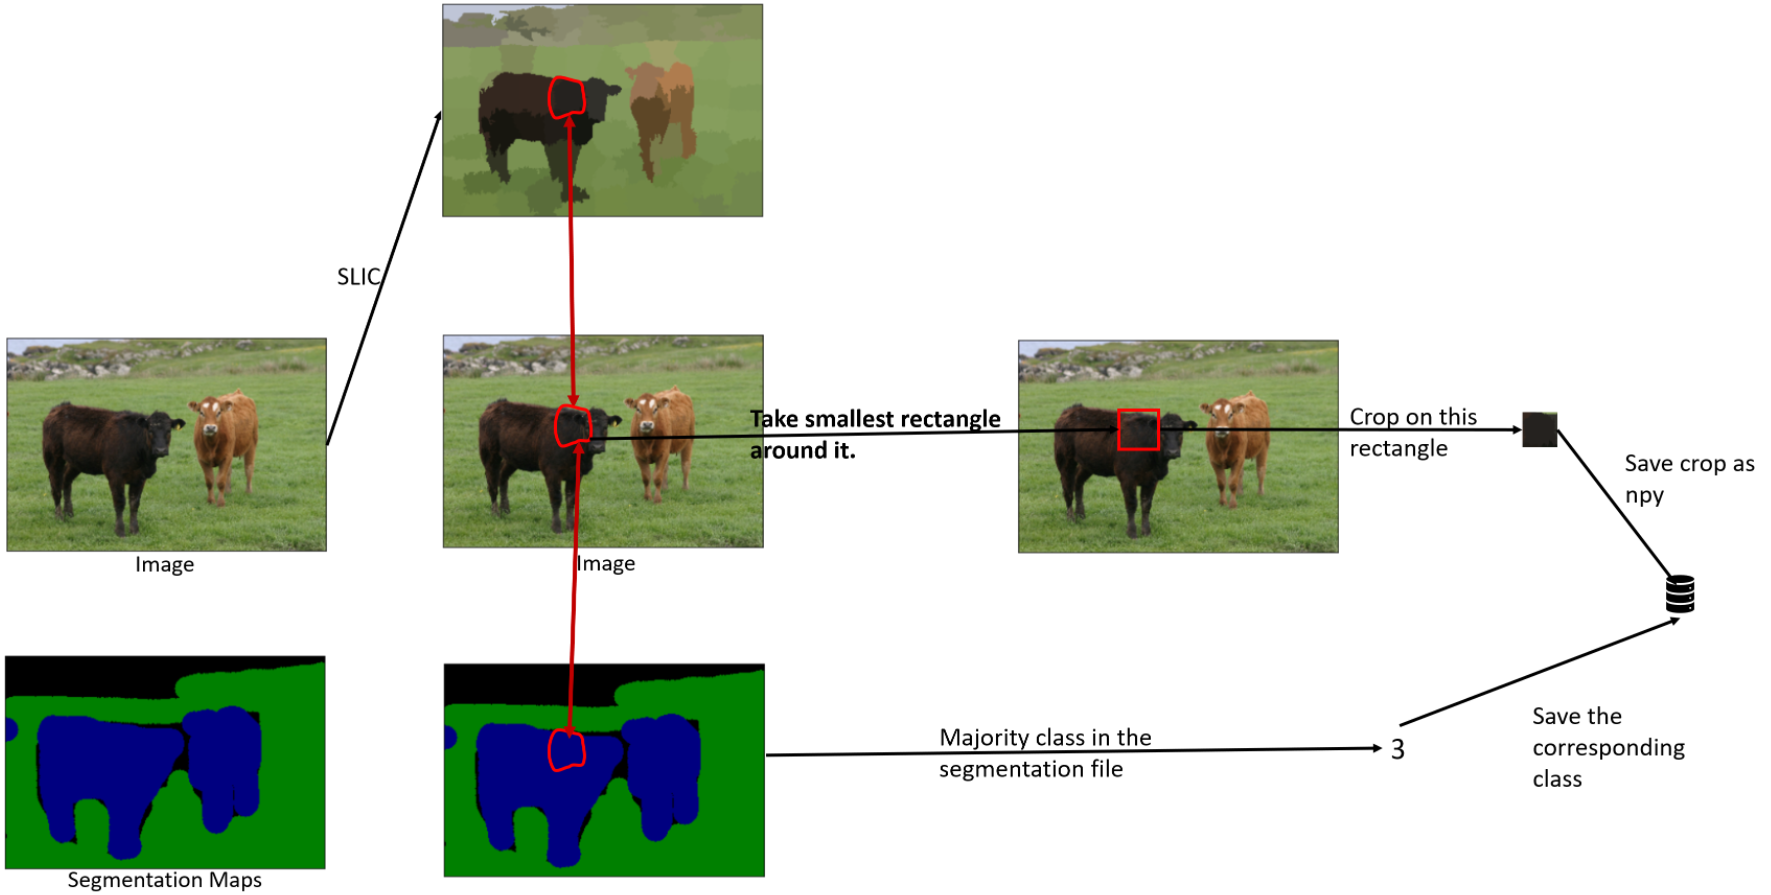


In addition to your code, **the primary graded deliverables** for this question are the 12 demo images we request after you have written code for the dataset.

In [ ]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os

from tqdm import tqdm
import pandas as pd

def make_dir(directory):
  dir_path = os.path.join(msrc_directory, directory)
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  return dir_path


datasets_dir = 'datasets'
train_dir = 'datasets/train'
test_dir = 'datasets/test'
datasets_path = os.path.join(msrc_directory, datasets_dir)
if not os.path.exists(datasets_path):
  os.mkdir(datasets_path)


datasets_path = make_dir(datasets_dir)
training_path = make_dir(train_dir)
testing_path = make_dir(test_dir)

In [ ]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10)
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt
# Alternatively, you don't save the segment patch and ID label offline, instead,
# you process them on the fly later.

# if os.path.exists('./datasets/train.txt'):
#     os.remove('./datasets/train.txt')

files = os.listdir(msrc_directory)
total_images = len(files)
#80-20 SPLIT
training_size = int(len(files) * 0.8)
testing_size = total_images - training_size

train_files = files[:training_size]
test_files = files[training_size:]


# for filename in os.listdir(msrc_directory):
#     # Your code
#     pass



In [ ]:
def give_rectangular_patch(list_of_indices):
  y_list = list_of_indices[0]
  x_list = list_of_indices[1]
  x_min, x_max = min(x_list), max(x_list)
  y_min, y_max = min(y_list), max(y_list)
  return x_min, x_max, y_min, y_max


def dilate(rectangle_patch_location, Height, Width):
  x_min, x_max, y_min, y_max = rectangle_patch_location
  pixels_dilate=3# pixel to dilate the patch with
  x_min = max(0, x_min -   pixels_dilate)
  y_min = max(0, y_min -   pixels_dilate)

  x_max = min(Width, x_max + pixels_dilate)
  y_max = max(Height, y_max + pixels_dilate)

  return x_min, x_max, y_min, y_max


def rectangle_patch_location(segmap, segmented_labels):
  Height, Width = segmap.shape
  seg_label_index = np.where(segmap == segmented_labels)
  if len(seg_label_index[0]) == 0:
    return None
  rectangle_patch_location = give_rectangular_patch(seg_label_index)
  # dilate the rectangular superpixel patch
  rectangle_patch_location = dilate(rectangle_patch_location, Height, Width)
  return rectangle_patch_location


def crop_img(image, rect_patch_location):
  x_min, x_max, y_min, y_max = rect_patch_location
  cropped_image = image[y_min:y_max, x_min:x_max, :]
  return cropped_image

def Groundtruth_seg_class(Groundtruth_image_patch):
  # Due to negative labels having errors with pytorch so I added +1 to the labels.
  #initialize labels as zeros
  map = np.zeros(10)
  height, width = Groundtruth_image_patch.shape[:-1]
  for i in range(height):
    for j in range(width):
      Colour = tuple(Groundtruth_image_patch[i,j])
      labels = rgb_2_label.get(Colour, -1)
      map[labels+1] += 1

  segmented_class = np.argmax(map)


  return (segmented_class)


number_of_segments = 100 #given to do 100 segments in superpixels image
def crop_segments_save(segmented_map, source_image, groundtruth_image, image_filename, data_path, csv_files, text_file):
  for label in range(number_of_segments):
    rectangle_patch_loc = rectangle_patch_location(segmented_map, label)
    if rectangle_patch_loc is not None:
      sample_im_cropped = crop_img(source_image, rectangle_patch_loc)
      gt_im_cropped = crop_img(groundtruth_image, rectangle_patch_loc)
      segmented_class_label = Groundtruth_seg_class(gt_im_cropped)
      data_filename = image_filename.replace(".bmp", (f'_{label}_{".npy"}'))
      data_filename_path = f'{data_path}/{data_filename}'

      np.save(data_filename_path, sample_im_cropped)

      csv_files.append([data_filename, segmented_class_label])

      with open(f'{datasets_path}/{text_file}', 'a+') as textfile:
        textfile.write(data_filename + '\n')

In [ ]:

files = os.listdir(msrc_directory)
total_images = len(files)
training_size = int(len(files) * 0.8)
testing_size = total_images - training_size

train_files = files[:training_size]
test_files = files[training_size:]
# Your code
def create_dataset(list_file, data_path, csv_file, text_save):
  items = []
  for filename in tqdm(list_file, leave=False):
    if ".bmp" in filename and "_GT" not in filename:
      print(filename)
      source_filename = filename
      groundtruth_filename = filename.replace(".bmp", ("_GT"+".bmp"))

      source_filename = os.path.join(msrc_directory, source_filename)
      groundtruth_filename = os.path.join(msrc_directory, groundtruth_filename)

      source_image = cv2.imread(source_filename)
      groundtruth_image = cv2.imread(groundtruth_filename)
      #BGR to RGB for ground truth and sample image
      source_image = source_image[:,:,::-1]
      groundtruth_image = groundtruth_image[:,:,::-1]

      seg_map = slic(source_image, n_segments=number_of_segments, compactness=10)
      crop_segments_save(seg_map, source_image, groundtruth_image, filename, data_path, items, text_save)


  # create csv file:
  imagepath_label = pd.DataFrame(items, columns=['image_path', 'label'])
  imagepath_label.to_csv(f'{data_path}/{csv_file}')



create_dataset(train_files, training_path, 'train.csv', 'train.txt')
print('Finished generating training data')

create_dataset(test_files, testing_path, 'test.csv', 'test.txt')
print('Finished generating testing data')

  0%|          | 0/386 [00:00<?, ?it/s]

7_24_s.bmp


  1%|          | 3/386 [00:02<06:02,  1.06it/s]

2_25_s.bmp


  1%|          | 4/386 [00:05<09:28,  1.49s/it]

6_30_s.bmp


  2%|▏         | 9/386 [00:08<05:09,  1.22it/s]

4_9_s.bmp


  3%|▎         | 10/386 [00:11<07:20,  1.17s/it]

7_19_s.bmp


  3%|▎         | 13/386 [00:13<06:27,  1.04s/it]

8_9_s.bmp


  4%|▍         | 16/386 [00:16<05:55,  1.04it/s]

7_23_s.bmp


  4%|▍         | 17/386 [00:18<07:20,  1.19s/it]

2_2_s.bmp


  5%|▌         | 20/386 [00:21<06:28,  1.06s/it]

2_22_s.bmp


  5%|▌         | 21/386 [00:23<07:50,  1.29s/it]

4_24_s.bmp


  6%|▌         | 22/386 [00:26<09:39,  1.59s/it]

2_17_s.bmp


  7%|▋         | 26/386 [00:28<06:26,  1.07s/it]

3_9_s.bmp


  8%|▊         | 29/386 [00:31<05:53,  1.01it/s]

5_22_s.bmp


  8%|▊         | 30/386 [00:34<07:20,  1.24s/it]

5_28_s.bmp


  8%|▊         | 32/386 [00:36<07:27,  1.26s/it]

6_17_s.bmp


  9%|▉         | 35/386 [00:39<06:32,  1.12s/it]

3_29_s.bmp


 10%|▉         | 37/386 [00:41<06:38,  1.14s/it]

6_18_s.bmp


 10%|▉         | 38/386 [00:44<08:04,  1.39s/it]

3_23_s.bmp


 10%|█         | 39/386 [00:46<09:06,  1.57s/it]

3_1_s.bmp


 11%|█         | 41/386 [00:49<08:04,  1.41s/it]

4_22_s.bmp


 11%|█         | 42/386 [00:51<09:39,  1.68s/it]

6_2_s.bmp


 11%|█         | 43/386 [00:54<10:20,  1.81s/it]

1_18_s.bmp


 12%|█▏        | 45/386 [00:56<09:11,  1.62s/it]

2_23_s.bmp


 13%|█▎        | 49/386 [00:58<05:47,  1.03s/it]

3_28_s.bmp


 13%|█▎        | 51/386 [01:01<06:00,  1.08s/it]

7_6_s.bmp


 13%|█▎        | 52/386 [01:03<06:57,  1.25s/it]

6_10_s.bmp


 14%|█▎        | 53/386 [01:05<08:18,  1.50s/it]

3_16_s.bmp


 14%|█▍        | 54/386 [01:08<09:24,  1.70s/it]

5_2_s.bmp


 14%|█▍        | 55/386 [01:10<10:25,  1.89s/it]

6_15_s.bmp


 15%|█▍        | 56/386 [01:13<10:54,  1.98s/it]

8_30_s.bmp


 15%|█▌        | 59/386 [01:15<07:03,  1.29s/it]

5_6_s.bmp


 16%|█▌        | 61/386 [01:17<07:08,  1.32s/it]

4_1_s.bmp


 16%|█▌        | 62/386 [01:20<08:37,  1.60s/it]

4_5_s.bmp


 17%|█▋        | 65/386 [01:23<07:12,  1.35s/it]

3_2_s.bmp


 17%|█▋        | 67/386 [01:26<07:27,  1.40s/it]

7_22_s.bmp


 18%|█▊        | 68/386 [01:29<08:52,  1.67s/it]

2_11_s.bmp


 18%|█▊        | 69/386 [01:31<08:57,  1.70s/it]

1_20_s.bmp


 18%|█▊        | 70/386 [01:34<10:05,  1.92s/it]

4_11_s.bmp


 19%|█▊        | 72/386 [01:36<08:50,  1.69s/it]

7_29_s.bmp


 19%|█▉        | 74/386 [01:39<07:58,  1.53s/it]

5_12_s.bmp


 19%|█▉        | 75/386 [01:41<08:57,  1.73s/it]

5_19_s.bmp


 20%|██        | 78/386 [01:44<06:51,  1.34s/it]

4_2_s.bmp


 20%|██        | 79/386 [01:47<07:58,  1.56s/it]

4_19_s.bmp


 21%|██        | 80/386 [01:49<09:09,  1.80s/it]

6_8_s.bmp


 21%|██        | 81/386 [01:52<10:06,  1.99s/it]

1_30_s.bmp


 22%|██▏       | 83/386 [01:54<08:31,  1.69s/it]

1_26_s.bmp


 22%|██▏       | 85/386 [01:57<07:42,  1.54s/it]

4_15_s.bmp


 23%|██▎       | 90/386 [02:00<04:49,  1.02it/s]

7_14_s.bmp


 24%|██▍       | 93/386 [02:03<04:55,  1.01s/it]

2_10_s.bmp


 25%|██▍       | 95/386 [02:05<04:47,  1.01it/s]

5_8_s.bmp


 25%|██▌       | 97/386 [02:07<05:09,  1.07s/it]

2_8_s.bmp


 25%|██▌       | 98/386 [02:10<06:25,  1.34s/it]

7_17_s.bmp


 26%|██▌       | 99/386 [02:13<07:35,  1.59s/it]

5_3_s.bmp


 26%|██▌       | 100/386 [02:16<08:45,  1.84s/it]

8_22_s.bmp


 26%|██▋       | 102/386 [02:18<07:41,  1.62s/it]

7_25_s.bmp


 27%|██▋       | 103/386 [02:21<08:51,  1.88s/it]

5_9_s.bmp


 27%|██▋       | 105/386 [02:23<07:20,  1.57s/it]

8_23_s.bmp


 28%|██▊       | 107/386 [02:25<06:32,  1.41s/it]

7_20_s.bmp


 29%|██▉       | 111/386 [02:28<04:42,  1.03s/it]

8_6_s.bmp


 29%|██▉       | 112/386 [02:30<05:38,  1.24s/it]

1_16_s.bmp


 30%|██▉       | 114/386 [02:34<06:07,  1.35s/it]

1_29_s.bmp


 31%|███       | 118/386 [02:36<04:31,  1.01s/it]

8_28_s.bmp


 31%|███       | 119/386 [02:38<04:53,  1.10s/it]

7_8_s.bmp


 32%|███▏      | 122/386 [02:41<04:36,  1.05s/it]

4_23_s.bmp


 33%|███▎      | 126/386 [02:44<04:05,  1.06it/s]

3_10_s.bmp


 33%|███▎      | 127/386 [02:46<04:52,  1.13s/it]

4_27_s.bmp


 33%|███▎      | 128/386 [02:49<06:06,  1.42s/it]

3_24_s.bmp


 34%|███▎      | 130/386 [02:52<06:07,  1.44s/it]

6_29_s.bmp


 34%|███▍      | 133/386 [02:55<05:17,  1.26s/it]

2_5_s.bmp


 35%|███▍      | 134/386 [02:58<06:41,  1.59s/it]

6_5_s.bmp


 35%|███▌      | 136/386 [03:01<06:21,  1.53s/it]

8_24_s.bmp


 35%|███▌      | 137/386 [03:03<06:57,  1.68s/it]

8_11_s.bmp


 36%|███▌      | 138/386 [03:06<07:24,  1.79s/it]

7_7_s.bmp


 37%|███▋      | 141/386 [03:08<05:25,  1.33s/it]

1_22_s.bmp


 38%|███▊      | 145/386 [03:11<04:02,  1.00s/it]

8_21_s.bmp


 38%|███▊      | 147/386 [03:12<03:49,  1.04it/s]

1_10_s.bmp


 38%|███▊      | 148/386 [03:15<05:05,  1.28s/it]

6_25_s.bmp


 39%|███▉      | 150/386 [03:18<05:17,  1.34s/it]

4_8_s.bmp


 40%|███▉      | 154/386 [03:22<04:10,  1.08s/it]

3_22_s.bmp


 40%|████      | 156/386 [03:24<04:21,  1.14s/it]

5_11_s.bmp


 41%|████▏     | 160/386 [03:27<03:36,  1.04it/s]

7_5_s.bmp


 42%|████▏     | 164/386 [03:30<03:10,  1.17it/s]

8_1_s.bmp


 43%|████▎     | 166/386 [03:32<03:22,  1.09it/s]

4_14_s.bmp


 44%|████▎     | 168/386 [03:35<03:41,  1.02s/it]

6_12_s.bmp


 44%|████▍     | 169/386 [03:37<04:27,  1.23s/it]

3_14_s.bmp


 44%|████▍     | 170/386 [03:40<05:24,  1.50s/it]

4_25_s.bmp


 45%|████▍     | 173/386 [03:43<04:32,  1.28s/it]

7_26_s.bmp


 45%|████▌     | 174/386 [03:46<05:20,  1.51s/it]

3_26_s.bmp


 46%|████▌     | 177/386 [03:48<04:05,  1.18s/it]

6_1_s.bmp


 47%|████▋     | 181/386 [03:50<03:06,  1.10it/s]

7_18_s.bmp


 47%|████▋     | 182/386 [03:52<03:47,  1.11s/it]

5_30_s.bmp


 48%|████▊     | 187/386 [03:55<02:46,  1.19it/s]

4_13_s.bmp


 50%|████▉     | 192/386 [03:58<02:19,  1.39it/s]

7_16_s.bmp


 50%|█████     | 193/386 [04:01<02:55,  1.10it/s]

1_19_s.bmp


 50%|█████     | 194/386 [04:03<03:42,  1.16s/it]

4_3_s.bmp


 51%|█████     | 195/386 [04:06<04:27,  1.40s/it]

6_4_s.bmp


 52%|█████▏    | 201/386 [04:09<02:43,  1.13it/s]

1_23_s.bmp


 53%|█████▎    | 204/386 [04:12<02:39,  1.14it/s]

6_24_s.bmp


 53%|█████▎    | 206/386 [04:14<02:53,  1.04it/s]

5_20_s.bmp


 54%|█████▍    | 208/386 [04:17<03:12,  1.08s/it]

2_15_s.bmp


 54%|█████▍    | 210/386 [04:19<02:59,  1.02s/it]

4_4_s.bmp


 55%|█████▍    | 211/386 [04:22<03:46,  1.29s/it]

6_9_s.bmp


 55%|█████▍    | 212/386 [04:24<04:28,  1.54s/it]

3_8_s.bmp


 55%|█████▌    | 213/386 [04:26<04:32,  1.57s/it]

7_1_s.bmp


 56%|█████▋    | 218/386 [04:29<02:57,  1.05s/it]

4_17_s.bmp


 57%|█████▋    | 219/386 [04:33<03:49,  1.38s/it]

4_28_s.bmp


 57%|█████▋    | 220/386 [04:35<04:25,  1.60s/it]

8_16_s.bmp


 57%|█████▋    | 221/386 [04:37<04:35,  1.67s/it]

2_26_s.bmp


 58%|█████▊    | 222/386 [04:39<04:42,  1.72s/it]

8_12_s.bmp


 59%|█████▊    | 226/386 [04:42<03:08,  1.18s/it]

5_27_s.bmp


 59%|█████▉    | 228/386 [04:44<03:03,  1.16s/it]

2_21_s.bmp


 62%|██████▏   | 241/386 [04:47<01:07,  2.16it/s]

1_7_s.bmp


 63%|██████▎   | 242/386 [04:50<01:32,  1.56it/s]

1_5_s.bmp


 63%|██████▎   | 243/386 [04:53<02:00,  1.18it/s]

3_6_s.bmp


 63%|██████▎   | 244/386 [04:55<02:30,  1.06s/it]

7_4_s.bmp


 64%|██████▍   | 247/386 [04:58<02:16,  1.01it/s]

3_20_s.bmp


 65%|██████▍   | 249/386 [05:00<02:22,  1.04s/it]

5_26_s.bmp


 65%|██████▌   | 251/386 [05:03<02:36,  1.16s/it]

7_15_s.bmp


 65%|██████▌   | 252/386 [05:06<03:11,  1.43s/it]

3_7_s.bmp


 66%|██████▌   | 255/386 [05:09<02:33,  1.17s/it]

2_29_s.bmp


 66%|██████▋   | 256/386 [05:11<02:51,  1.32s/it]

8_14_s.bmp


 67%|██████▋   | 258/386 [05:13<02:33,  1.20s/it]

1_15_s.bmp


 68%|██████▊   | 261/386 [05:15<02:15,  1.09s/it]

3_4_s.bmp


 68%|██████▊   | 264/386 [05:18<02:01,  1.00it/s]

2_24_s.bmp


 70%|██████▉   | 270/386 [05:20<01:14,  1.56it/s]

7_10_s.bmp


 70%|███████   | 272/386 [05:23<01:33,  1.22it/s]

6_28_s.bmp


 72%|███████▏  | 278/386 [05:25<01:11,  1.52it/s]

3_11_s.bmp


 72%|███████▏  | 279/386 [05:28<01:31,  1.16it/s]

4_6_s.bmp


 73%|███████▎  | 281/386 [05:31<01:40,  1.05it/s]

2_20_s.bmp


 73%|███████▎  | 282/386 [05:34<02:09,  1.25s/it]

6_22_s.bmp


 73%|███████▎  | 283/386 [05:36<02:26,  1.43s/it]

5_21_s.bmp


 74%|███████▎  | 284/386 [05:39<02:55,  1.72s/it]

5_10_s.bmp


 74%|███████▍  | 286/386 [05:42<02:35,  1.56s/it]

6_16_s.bmp


 74%|███████▍  | 287/386 [05:44<02:53,  1.75s/it]

8_4_s.bmp


 75%|███████▌  | 290/386 [05:45<01:48,  1.13s/it]

2_13_s.bmp


 76%|███████▋  | 295/386 [05:49<01:19,  1.15it/s]

4_18_s.bmp


 77%|███████▋  | 296/386 [05:51<01:41,  1.12s/it]

1_2_s.bmp


 77%|███████▋  | 297/386 [05:52<01:37,  1.10s/it]

8_25_s.bmp


 77%|███████▋  | 299/386 [05:54<01:33,  1.07s/it]

3_13_s.bmp


 78%|███████▊  | 301/386 [05:57<01:33,  1.10s/it]

4_16_s.bmp


 78%|███████▊  | 302/386 [05:59<01:56,  1.39s/it]

6_19_s.bmp


 79%|███████▉  | 305/386 [06:01<01:25,  1.06s/it]

5_25_s.bmp


 79%|███████▉  | 306/386 [06:04<01:47,  1.35s/it]

3_5_s.bmp


 80%|███████▉  | 307/386 [06:07<02:02,  1.55s/it]

5_15_s.bmp


 80%|███████▉  | 308/386 [06:09<02:22,  1.83s/it]

1_4_s.bmp


 80%|████████  | 310/386 [06:11<01:53,  1.50s/it]

8_20_s.bmp


 81%|████████  | 311/386 [06:13<01:55,  1.54s/it]

8_29_s.bmp


 81%|████████  | 312/386 [06:15<01:55,  1.57s/it]

1_13_s.bmp


 81%|████████  | 313/386 [06:17<02:17,  1.89s/it]

7_11_s.bmp


 82%|████████▏ | 316/386 [06:20<01:39,  1.42s/it]

8_17_s.bmp


 82%|████████▏ | 318/386 [06:22<01:24,  1.24s/it]

1_25_s.bmp


 83%|████████▎ | 319/386 [06:25<01:41,  1.51s/it]

1_8_s.bmp


 83%|████████▎ | 320/386 [06:28<01:56,  1.77s/it]

8_10_s.bmp


 83%|████████▎ | 321/386 [06:29<01:56,  1.80s/it]

5_13_s.bmp


 83%|████████▎ | 322/386 [06:32<02:06,  1.97s/it]

4_10_s.bmp


 84%|████████▎ | 323/386 [06:35<02:18,  2.20s/it]

8_19_s.bmp


 84%|████████▍ | 324/386 [06:37<02:11,  2.12s/it]

1_6_s.bmp


 84%|████████▍ | 326/386 [06:39<01:39,  1.67s/it]

3_25_s.bmp


 85%|████████▍ | 328/386 [06:42<01:30,  1.56s/it]

8_5_s.bmp


 85%|████████▌ | 329/386 [06:44<01:39,  1.75s/it]

1_12_s.bmp


 86%|████████▋ | 333/386 [06:46<00:55,  1.05s/it]

6_21_s.bmp


 87%|████████▋ | 334/386 [06:49<01:10,  1.36s/it]

1_11_s.bmp


 87%|████████▋ | 335/386 [06:52<01:22,  1.62s/it]

4_26_s.bmp


 87%|████████▋ | 336/386 [06:55<01:34,  1.89s/it]

3_18_s.bmp


 87%|████████▋ | 337/386 [06:57<01:39,  2.04s/it]

1_1_s.bmp


 88%|████████▊ | 339/386 [06:59<01:18,  1.67s/it]

4_12_s.bmp


 89%|████████▉ | 343/386 [07:02<00:49,  1.15s/it]

1_27_s.bmp


 89%|████████▉ | 344/386 [07:05<00:59,  1.41s/it]

7_13_s.bmp


 90%|█████████ | 349/386 [07:08<00:37,  1.00s/it]

2_28_s.bmp


 91%|█████████ | 351/386 [07:10<00:36,  1.05s/it]

2_3_s.bmp


 92%|█████████▏| 356/386 [07:13<00:23,  1.28it/s]

8_8_s.bmp


 92%|█████████▏| 357/386 [07:15<00:28,  1.03it/s]

4_30_s.bmp


 93%|█████████▎| 359/386 [07:18<00:30,  1.12s/it]

5_24_s.bmp


 94%|█████████▎| 361/386 [07:21<00:29,  1.16s/it]

3_17_s.bmp


 94%|█████████▍| 363/386 [07:23<00:27,  1.18s/it]

3_21_s.bmp


 94%|█████████▍| 364/386 [07:26<00:31,  1.43s/it]

5_14_s.bmp


 95%|█████████▍| 365/386 [07:29<00:35,  1.69s/it]

7_12_s.bmp


 95%|█████████▌| 367/386 [07:32<00:31,  1.65s/it]

2_19_s.bmp


 95%|█████████▌| 368/386 [07:35<00:32,  1.83s/it]

8_2_s.bmp


 96%|█████████▌| 369/386 [07:37<00:32,  1.91s/it]

3_15_s.bmp


 96%|█████████▌| 371/386 [07:39<00:24,  1.66s/it]

7_2_s.bmp


 97%|█████████▋| 374/386 [07:42<00:15,  1.30s/it]

6_11_s.bmp


 97%|█████████▋| 375/386 [07:45<00:17,  1.58s/it]

7_3_s.bmp


 97%|█████████▋| 376/386 [07:48<00:18,  1.87s/it]

6_3_s.bmp


 98%|█████████▊| 377/386 [07:51<00:19,  2.16s/it]

5_17_s.bmp


 98%|█████████▊| 378/386 [07:54<00:18,  2.33s/it]

2_12_s.bmp


 99%|█████████▉| 382/386 [07:56<00:04,  1.22s/it]

3_3_s.bmp


 99%|█████████▉| 383/386 [07:59<00:04,  1.57s/it]

6_7_s.bmp


100%|█████████▉| 385/386 [08:02<00:01,  1.51s/it]

4_20_s.bmp


Finished generating training data


  0%|          | 0/97 [00:00<?, ?it/s]

2_7_s.bmp


  1%|          | 1/97 [00:02<03:32,  2.22s/it]

1_28_s.bmp


  2%|▏         | 2/97 [00:04<03:47,  2.39s/it]

8_3_s.bmp


  3%|▎         | 3/97 [00:06<03:03,  1.95s/it]

4_7_s.bmp


  5%|▌         | 5/97 [00:09<02:33,  1.67s/it]

5_18_s.bmp


  6%|▌         | 6/97 [00:11<02:56,  1.94s/it]

2_6_s.bmp


  7%|▋         | 7/97 [00:14<03:16,  2.19s/it]

1_24_s.bmp


 10%|█         | 10/97 [00:17<02:08,  1.48s/it]

7_30_s.bmp


 12%|█▏        | 12/97 [00:20<02:08,  1.51s/it]

5_1_s.bmp


 13%|█▎        | 13/97 [00:22<02:14,  1.60s/it]

7_9_s.bmp


 18%|█▊        | 17/97 [00:24<01:28,  1.11s/it]

3_12_s.bmp


 22%|██▏       | 21/97 [00:27<01:10,  1.07it/s]

3_30_s.bmp


 24%|██▎       | 23/97 [00:29<01:09,  1.06it/s]

2_1_s.bmp


 27%|██▋       | 26/97 [00:32<01:08,  1.03it/s]

2_9_s.bmp


 28%|██▊       | 27/97 [00:35<01:23,  1.19s/it]

6_13_s.bmp


 30%|██▉       | 29/97 [00:38<01:25,  1.26s/it]

5_4_s.bmp


 31%|███       | 30/97 [00:40<01:38,  1.47s/it]

5_29_s.bmp


 33%|███▎      | 32/97 [00:43<01:34,  1.46s/it]

6_6_s.bmp


 36%|███▌      | 35/97 [00:46<01:18,  1.26s/it]

1_17_s.bmp


 38%|███▊      | 37/97 [00:49<01:21,  1.35s/it]

6_27_s.bmp


 40%|████      | 39/97 [00:52<01:19,  1.37s/it]

6_26_s.bmp


 41%|████      | 40/97 [00:55<01:31,  1.61s/it]

5_16_s.bmp


 43%|████▎     | 42/97 [00:57<01:22,  1.50s/it]

2_18_s.bmp


 45%|████▌     | 44/97 [01:00<01:17,  1.45s/it]

5_23_s.bmp


 46%|████▋     | 45/97 [01:03<01:27,  1.68s/it]

7_21_s.bmp


 49%|████▉     | 48/97 [01:06<01:06,  1.36s/it]

6_14_s.bmp


 51%|█████     | 49/97 [01:09<01:19,  1.65s/it]

8_18_s.bmp


 52%|█████▏    | 50/97 [01:11<01:26,  1.85s/it]

5_7_s.bmp


 55%|█████▍    | 53/97 [01:14<01:04,  1.48s/it]

3_27_s.bmp


 57%|█████▋    | 55/97 [01:17<00:56,  1.35s/it]

8_13_s.bmp


 58%|█████▊    | 56/97 [01:19<01:00,  1.48s/it]

8_7_s.bmp


 59%|█████▉    | 57/97 [01:21<01:03,  1.59s/it]

7_28_s.bmp


 62%|██████▏   | 60/97 [01:23<00:45,  1.22s/it]

6_20_s.bmp


 64%|██████▍   | 62/97 [01:26<00:45,  1.30s/it]

1_3_s.bmp


 65%|██████▍   | 63/97 [01:28<00:47,  1.39s/it]

2_30_s.bmp


 67%|██████▋   | 65/97 [01:30<00:43,  1.37s/it]

4_29_s.bmp


 68%|██████▊   | 66/97 [01:34<00:52,  1.69s/it]

2_14_s.bmp


 69%|██████▉   | 67/97 [01:37<01:01,  2.04s/it]

1_9_s.bmp


 70%|███████   | 68/97 [01:40<01:04,  2.22s/it]

5_5_s.bmp


 72%|███████▏  | 70/97 [01:42<00:48,  1.79s/it]

1_21_s.bmp


 78%|███████▊  | 76/97 [01:45<00:19,  1.06it/s]

4_21_s.bmp


 82%|████████▏ | 80/97 [01:47<00:14,  1.18it/s]

2_4_s.bmp


 84%|████████▎ | 81/97 [01:50<00:16,  1.06s/it]

1_14_s.bmp


 85%|████████▍ | 82/97 [01:53<00:19,  1.32s/it]

7_27_s.bmp


 87%|████████▋ | 84/97 [01:56<00:17,  1.35s/it]

8_27_s.bmp


 89%|████████▊ | 86/97 [01:58<00:14,  1.29s/it]

8_15_s.bmp


 94%|█████████▍| 91/97 [02:00<00:05,  1.16it/s]

2_16_s.bmp


 96%|█████████▌| 93/97 [02:02<00:03,  1.17it/s]

2_27_s.bmp


 97%|█████████▋| 94/97 [02:04<00:03,  1.05s/it]

8_26_s.bmp


 98%|█████████▊| 95/97 [02:06<00:02,  1.18s/it]

6_23_s.bmp


 99%|█████████▉| 96/97 [02:09<00:01,  1.43s/it]

3_19_s.bmp


Finished generating testing data


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import copy
# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):
    def __init__(self, data_path, csv_file, transform=None):
      # Your code
      self.data = pd.read_csv(f'{data_path}/{csv_file}', skiprows=1, header=None)
      self.data_size = len(self.data)
      self.data_path = data_path
      self.transform = transform


    def __len__(self):
      # Your code
      return self.data_size


    def __getitem__(self, index):
      # Your code
      filename = self.data.iloc[index, 1]
      image_path = f'{self.data_path}/{filename}'
      image = np.load(image_path, allow_pickle=True)
      label_y = int(self.data.iloc[index, 2])

      data_y = torch.tensor(label_y)
      if self.transform:
        image = self.transform(image)

      return (image, label_y)

Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

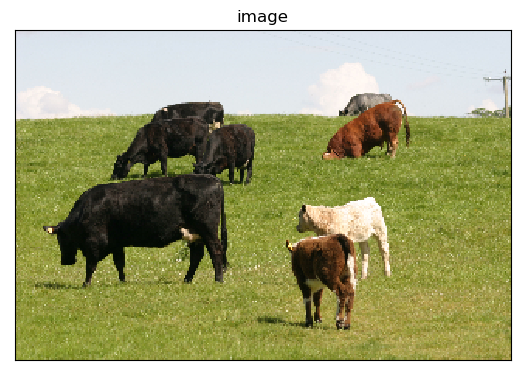

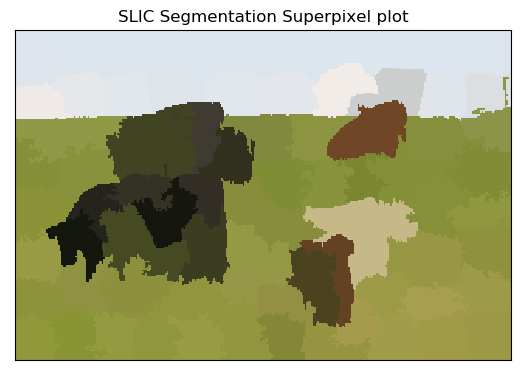

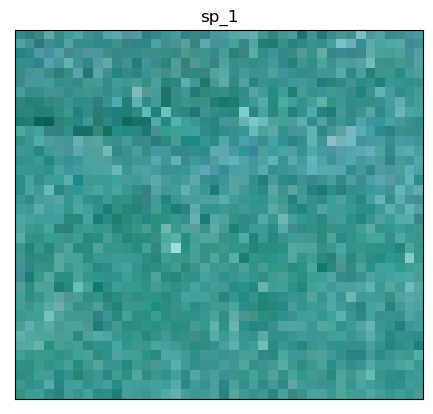

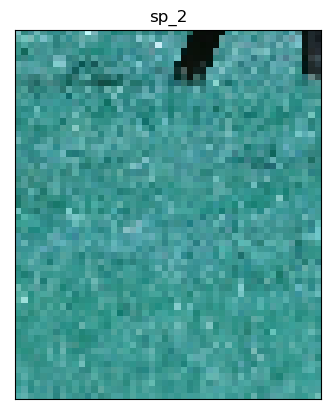

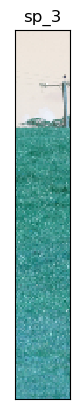

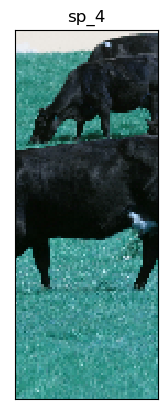

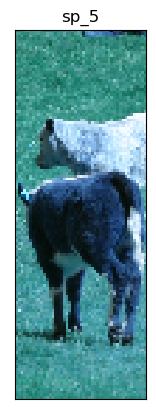

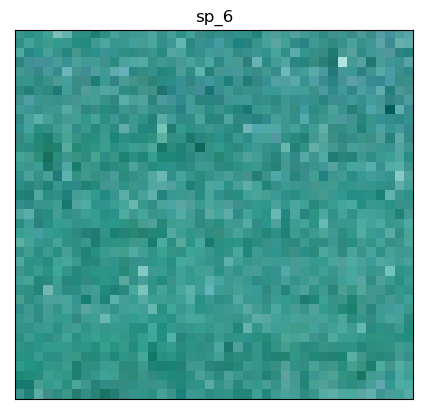

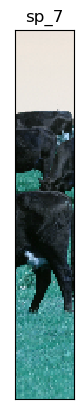

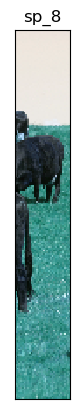

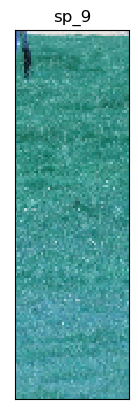

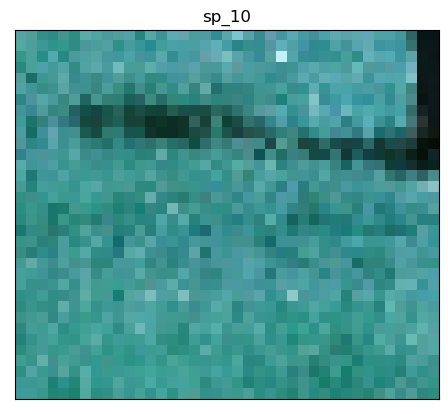

In [ ]:
### YOUR CODE TO PLOT 12 images (original RGB + superpixel map + first 10 superpixels) ###
import glob
import cv2
test_image_name = "1_11_s.bmp"
test_image = cv2.imread(os.path.join(msrc_directory,"1_11_s.bmp"))

segments= slic(test_image, n_segments=100, compactness=10)
plot_image(test_image, 'image')

superpixel_plot(test_image, segments, title = "SLIC Segmentation Superpixel plot")
i=0
print()
for file_name in glob.glob(msrc_directory+"/**/*.npy", recursive = True):

  test_image_name=test_image_name.replace(".bmp","")

  if test_image_name in file_name:
    i=i+1
    plot_image(np.load(file_name),"sp_"+str(i))
    if i == 10:
      break


In [ ]:
is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    print("Using CUDA")
device = torch.device("cuda:0" if is_cuda_available else "cpu")
print(device)

Using CUDA
cuda:0


### Question 6: Deep Network (10 points)

You could use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [ ]:
# Model definition
#Using RESNET18 pretrained model and replacing last layers with fully connected layer
class SegmentationNN(nn.Module):
    def __init__(self):
        super(SegmentationNN, self).__init__()

        self.super_res_net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.super_res_net.fc=nn.Linear(512,10)

        for param in self.super_res_net.parameters():
            param.requires_grad = False

        for param in self.super_res_net.fc.parameters():
            param.requires_grad=True
        self.softmax_layer=nn.Softmax(dim=-1)
        print(self.super_res_net)
        self.super_res_net.to(device)

    def forward(self, x):
        y = self.super_res_net(x)

        return y

### Question 7: Optimizer (10 points)

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm.

In [ ]:


# hyperparameters
number_of_epochs = 15
learning_rate = 1e-3
# Optimizer
import time
class Solver(object):
    def __init__(self, super_res_net, learning_rate=learning_rate):
      self.super_res_net = super_res_net
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.Adam(super_res_net.parameters(), lr=learning_rate)
      self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=5, verbose=True
      )
      #Create list for accuracy and losses
      self.epoch_accuracy = []
      self.epoch_loss = []
      self.running_loss = []
      self.running_acc = []

    def train(self, data_loader):
        # Your code
        self.best_accuracy=0.0
        self.super_res_net.train()
        starting_time = time.time()
        for epoch in range(number_of_epochs):
          list_losses = []
          running_corrects = 0
          n_sample = 0
          best_accuracy=0.0
          best_model_wts = copy.deepcopy(self.super_res_net.state_dict())
          data= tqdm(enumerate(data_loader), total=len(data_loader), leave=True)

          for idx, (inputs, labels) in data:

            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            # forward
            pred_labels = self.super_res_net(inputs)
            _, preds = torch.max(pred_labels, 1)

            loss = self.criterion(pred_labels, labels)

            list_losses.append(loss.item())

            running_corrects += torch.sum(preds == labels)
            n_sample += pred_labels.size(0)


            self.optimizer.zero_grad()
            loss.backward()

            self.optimizer.step()

            data.set_description(f'Epoch [{epoch}/{number_of_epochs}]')
            data.set_postfix(loss=loss.item(), acc=(running_corrects/n_sample).item())

            self.running_loss.append(sum(list_losses)/len(list_losses))

          average_loss = sum(list_losses)/len(list_losses)
          average_accuracy = running_corrects/n_sample
          self.scheduler.step(average_loss)

          self.epoch_accuracy.append(average_accuracy)
          self.epoch_loss.append(average_loss)

          time_diff = time.time() - starting_time
          print('Epoch: [{}/{}] Time: {}min:{}sec Training Loss: {:.4f} Acc: {:.4f}'.format(epoch, number_of_epochs, time_diff//60, time_diff%60, average_loss, average_accuracy))

    def testing(self, data_loader):
        self.super_res_net.eval()
        self.epoch_acc = []
        start = time.time()
        for epoch in range(number_of_epochs):
          running_corrects = 0
          n_sample = 0
          data = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
          with torch.no_grad():
            for _, (input, labels) in data:
              input = input.to(device=device)
              labels = labels.to(device=device)

              # forward
              pred_labels = self.super_res_net(input)
              _, preds = torch.max(pred_labels, 1)

              running_corrects += torch.sum(preds == labels)
              n_sample += pred_labels.size(0)

              data.set_description(f'Epoch [{epoch}/{number_of_epochs}]')
              data.set_postfix(acc=(running_corrects/n_sample).item())

          average_accuracy = running_corrects/n_sample

          self.epoch_acc.append(average_accuracy)

          time_diff = time.time() - start
          print('Epoch: [{}/{}] Time: {}min:{}sec Acc: {:.4f}'.format(epoch, number_of_epochs, time_diff//60, time_diff%60, average_accuracy))




### Question 8: Putting it together (50 points)

Train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's superpixel segmentation results.
The following 4 items are the primary graded components:

1. You must randomly split the whole dataset into train and test subset (80:20 split is fine).
2. You must show the training loss of the classifier after every epoch
3. You must show the training accuracy and test accuracy of the classifier after training.
4. You must plot as least one visualization showing the test segmentation map vs. ground truth segmentation map.

In [ ]:
transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])



# load the data
train_dataset = SegmentationData(training_path, 'train.csv', transform_train)
test_dataset = SegmentationData(testing_path, 'test.csv', transform_test)


# data loader
train_data_loader = data.DataLoader(dataset=train_dataset, batch_size=128 ,shuffle=True, num_workers=2)
test_data_loader = data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=True, num_workers=2)

dataiter = iter(train_data_loader)
data_samp = next(dataiter)
print(data_samp[0][0].shape)
#model
super_res_net = SegmentationNN()
# train the model

solver = Solver(super_res_net, learning_rate)
# start training
solver.train(train_data_loader)
print('Training Done!')

torch.Size([3, 224, 224])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

Epoch [0/15]: 100%|██████████| 90/90 [00:28<00:00,  3.21it/s, acc=0.651, loss=0.738]

Epoch: [0/15] Time: 0.0min:28.171237230300903sec Training Loss: 1.0808 Acc: 0.6509



Epoch [1/15]: 100%|██████████| 90/90 [00:22<00:00,  4.07it/s, acc=0.793, loss=0.474]

Epoch: [1/15] Time: 0.0min:50.441810131073sec Training Loss: 0.6116 Acc: 0.7927



Epoch [2/15]: 100%|██████████| 90/90 [00:22<00:00,  4.06it/s, acc=0.818, loss=0.454]

Epoch: [2/15] Time: 1.0min:12.766627550125122sec Training Loss: 0.5188 Acc: 0.8181



Epoch [3/15]: 100%|██████████| 90/90 [00:25<00:00,  3.58it/s, acc=0.834, loss=0.629]

Epoch: [3/15] Time: 1.0min:38.01956534385681sec Training Loss: 0.4746 Acc: 0.8343



Epoch [4/15]: 100%|██████████| 90/90 [00:22<00:00,  4.04it/s, acc=0.838, loss=0.352]

Epoch: [4/15] Time: 2.0min:0.5265746116638184sec Training Loss: 0.4447 Acc: 0.8384



Epoch [5/15]: 100%|██████████| 90/90 [00:22<00:00,  4.08it/s, acc=0.846, loss=0.46] 

Epoch: [5/15] Time: 2.0min:22.734110593795776sec Training Loss: 0.4278 Acc: 0.8456



Epoch [6/15]: 100%|██████████| 90/90 [00:21<00:00,  4.12it/s, acc=0.854, loss=0.386]

Epoch: [6/15] Time: 2.0min:44.70318675041199sec Training Loss: 0.4100 Acc: 0.8536



Epoch [7/15]: 100%|██████████| 90/90 [00:21<00:00,  4.13it/s, acc=0.858, loss=0.384]

Epoch: [7/15] Time: 3.0min:6.651939392089844sec Training Loss: 0.3963 Acc: 0.8582



Epoch [8/15]: 100%|██████████| 90/90 [00:21<00:00,  4.12it/s, acc=0.864, loss=0.425]

Epoch: [8/15] Time: 3.0min:28.624839544296265sec Training Loss: 0.3784 Acc: 0.8643



Epoch [9/15]: 100%|██████████| 90/90 [00:22<00:00,  4.09it/s, acc=0.865, loss=0.389]

Epoch: [9/15] Time: 3.0min:50.770721673965454sec Training Loss: 0.3720 Acc: 0.8646



Epoch [10/15]: 100%|██████████| 90/90 [00:22<00:00,  4.06it/s, acc=0.87, loss=0.358] 

Epoch: [10/15] Time: 4.0min:13.086344480514526sec Training Loss: 0.3617 Acc: 0.8696



Epoch [11/15]: 100%|██████████| 90/90 [00:22<00:00,  4.07it/s, acc=0.866, loss=0.236]

Epoch: [11/15] Time: 4.0min:35.34725832939148sec Training Loss: 0.3612 Acc: 0.8663



Epoch [12/15]: 100%|██████████| 90/90 [00:22<00:00,  4.06it/s, acc=0.874, loss=0.453]

Epoch: [12/15] Time: 4.0min:57.67282724380493sec Training Loss: 0.3471 Acc: 0.8740



Epoch [13/15]: 100%|██████████| 90/90 [00:22<00:00,  4.06it/s, acc=0.876, loss=0.454]

Epoch: [13/15] Time: 5.0min:19.95331072807312sec Training Loss: 0.3474 Acc: 0.8757



Epoch [14/15]: 100%|██████████| 90/90 [00:21<00:00,  4.10it/s, acc=0.874, loss=0.288]

Epoch: [14/15] Time: 5.0min:42.05187749862671sec Training Loss: 0.3421 Acc: 0.8739
Training Done!


In [ ]:
# del super_res_net
#   I am doing 80-20 split on data i.e, 20 is testing
solver.testing(test_data_loader)
print('testing finished. Lets go!')




Epoch [0/15]: 100%|██████████| 24/24 [00:05<00:00,  4.15it/s, acc=0.805]

Epoch: [0/15] Time: 0.0min:5.938882350921631sec Acc: 0.8050



Epoch [1/15]: 100%|██████████| 24/24 [00:05<00:00,  4.24it/s, acc=0.805]

Epoch: [1/15] Time: 0.0min:11.72918963432312sec Acc: 0.8050



Epoch [2/15]: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s, acc=0.805]

Epoch: [2/15] Time: 0.0min:17.49733304977417sec Acc: 0.8050



Epoch [3/15]: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s, acc=0.805]

Epoch: [3/15] Time: 0.0min:23.337915182113647sec Acc: 0.8050



Epoch [4/15]: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s, acc=0.805]

Epoch: [4/15] Time: 0.0min:29.15439224243164sec Acc: 0.8050



Epoch [5/15]: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s, acc=0.805]

Epoch: [5/15] Time: 0.0min:34.997843742370605sec Acc: 0.8050



Epoch [6/15]: 100%|██████████| 24/24 [00:05<00:00,  4.24it/s, acc=0.805]

Epoch: [6/15] Time: 0.0min:40.78106117248535sec Acc: 0.8050



Epoch [7/15]: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s, acc=0.805]

Epoch: [7/15] Time: 0.0min:46.59689784049988sec Acc: 0.8050



Epoch [8/15]: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s, acc=0.805]

Epoch: [8/15] Time: 0.0min:52.37264657020569sec Acc: 0.8050



Epoch [9/15]: 100%|██████████| 24/24 [00:05<00:00,  4.23it/s, acc=0.805]

Epoch: [9/15] Time: 0.0min:58.17456531524658sec Acc: 0.8050



Epoch [10/15]: 100%|██████████| 24/24 [00:05<00:00,  4.21it/s, acc=0.805]

Epoch: [10/15] Time: 1.0min:3.9951138496398926sec Acc: 0.8050



Epoch [11/15]: 100%|██████████| 24/24 [00:05<00:00,  4.24it/s, acc=0.805]

Epoch: [11/15] Time: 1.0min:9.786503314971924sec Acc: 0.8050



Epoch [12/15]: 100%|██████████| 24/24 [00:05<00:00,  4.21it/s, acc=0.805]

Epoch: [12/15] Time: 1.0min:15.63439655303955sec Acc: 0.8050



Epoch [13/15]: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s, acc=0.805]

Epoch: [13/15] Time: 1.0min:21.456085443496704sec Acc: 0.8050



Epoch [14/15]: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s, acc=0.805]

Epoch: [14/15] Time: 1.0min:27.30000591278076sec Acc: 0.8050
testing finished. Lets go!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


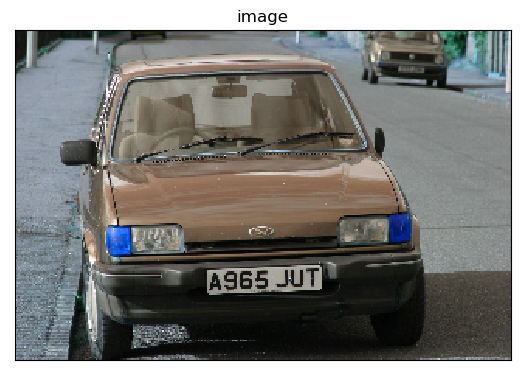

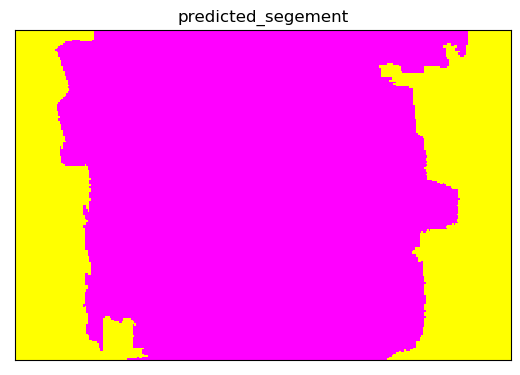

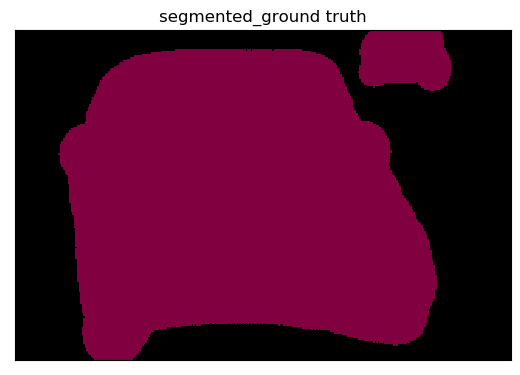

In [ ]:
files = os.listdir(msrc_directory)
total_images = len(files)
training_size = int(len(files) * 0.8)
testing_size = total_images - training_size
train_files = files[:training_size]
test_files = files[training_size:]
random_image=test_files[11]# took random image from test images our segmentation model

test_image_file=random_image
test_image_gt_filelocation = random_image.replace(".bmp", ("_GT"+".bmp"))

test_image_file = os.path.join(msrc_directory, test_image_file)
test_image_gt_filelocation = os.path.join(msrc_directory, test_image_gt_filelocation)

test_image = cv2.imread(test_image_file)
test_image_groundtruth = cv2.imread(test_image_gt_filelocation)
#convert bgr to rgb since cv2 gives bgr
test_image = test_image[:,:,::-1]
test_image_groundtruth = test_image_groundtruth[:,:,::-1]


segmented_map = slic(test_image, n_segments=100, compactness=10)
map_labels = {}
predicted_seg = np.zeros(test_image.shape)
super_res_net.eval()
for i in range(100):
  rect_loc = rectangle_patch_location(segmented_map, i)
  if rect_loc is not None:
    image_patch=crop_img(test_image,rect_loc)
    image_patch = transform_test(image_patch).to(device)
    cut_image = image_patch.unsqueeze(0)

    pred_labels = super_res_net(cut_image)
    _, preds = torch.max(pred_labels, 1)
    #-1 now since I did +1 in the model
    map_labels[i] = preds.item() - 1
    ind = (segmented_map == i)
    predicted_seg[ind] = labels_2_rgb[preds.item()-1]

plot_image(test_image, 'image')
plot_image(predicted_seg, 'predicted_segement')
plot_image(test_image_groundtruth, 'segmented_ground truth')

### Question 9: Bonus Question (20 points, OPTIONAL):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
# Bonus
